#  Chapter 1 DataCleaning and Exploratory Data Analysis

This first session deals with data cleaning, EDA and builing a simplistic model that can be used for predicting the sale price of houses in Ames, IOWA. Here we try to understand the dataset and get familiar with the methodology for developing an efficient model.

The next session contains a report that contains  the detailed analysis, interpretation, and information for the models. We will do a cross-validation and data splitting where the original data set is split into two data sets: the training set and the validation set. 



## The Data
There are two data sets included in the data folder: `Ames_Housing_Price_Data.csv` and `Ames_Real_Estate_Data.csv`.
The `Ames_Housing_Price_Data.csv` is a set of 2577 residential homes in Ames, Iowa, each described by 81 features. We will use it to predict the final logarithmic price of the houses using only 20 most interesting features

The `Ames_Housing_Price_Data.csv` set contains $81$ data columns, including the key feature **SalePrice** which will be used as the target of the predictive/descriptive modeling. **PID** refers to the land parcel ID, which can merged on the *MapRefNo* column of the **Ames Accessor Data** (`Ames_Real_Estate_Data.csv`) to find the property address. Using a free service, such as **geopy**, we can find the long-lat coordinates of the houses.

The columns of the data are mostly attributes associated with the land and the houses. There are size related attributes, quality and condition attributes, house attachment attributes, etc.

To establish a foundation for your team's data analytics, we offer some insights on the house sizes vs. prices.

## Outliers

The instructors' notes state:

> **Five observations** that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true **outliers** (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would **recommend removing any houses with more than
3700 square feet** from the data set (which eliminates these five unusual observations)
before assigning it to students.

To apply a more "rigorous" approach, outlier detection is conducted with a so-called Isolation Forest.

In [1]:
# Import the datasets and the libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statistics as stats
realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")
realEstate = realEstate[['MapRefNo','Prop_Addr','MA_Zip1']]
geocode_data =pd.read_csv("geocode_data.csv")

#Linear Models
from sklearn.linear_model import Lasso, ElasticNet


#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge


#Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingRegressor

#Random Forest
from sklearn.ensemble import RandomForestRegressor

#Support Vector Machines
from sklearn import svm

#Linear Regression
from sklearn import linear_model

#Make Pipeline
from sklearn.pipeline import make_pipeline

#Robust Scaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score


housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
housing.head()

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_7041/3672040398.py:14: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  realEstate = pd.read_csv("Ames_Real_Estate_Data.csv")


,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


<AxesSubplot:xlabel='Year', ylabel='SalePrice'>

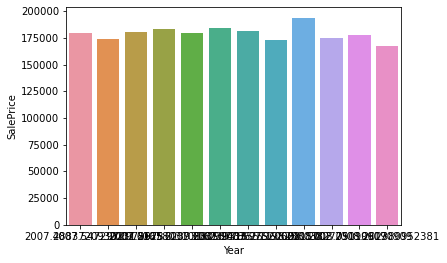

In [2]:
df = housing
df["Year"] = df["YrSold"]
df =df.groupby([ "MoSold"]).mean()

sns.barplot(data=df, x="Year", y="SalePrice")

In [3]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(housing)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [4]:

num_selector(housing)

['SalePrice',
 'PID',
 'GrLivArea',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'Year']

In [5]:
housing = housing[housing.GrLivArea<3700]
housing = housing[housing.LotArea<100000]
from scipy import stats
housing.shape

(2573, 82)

In [6]:
year = housing.groupby("YrSold").mean()
#plt.scatter(year[['GrLivArea']], year["SalePrice"])
year
#list(map(lambda x,y: x/y, housing.groupby("YrSold")["SalePrice"].mean(), housing.groupby("YrSold")["GrLivArea"].mean() ))


,SalePrice,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,Year
YrSold,,,,,,,,,,,,,,,,,,,,,
2006,176649.310078,7.116811e+08,1489.604651,61.870155,68.212617,10084.932171,6.009690,5.511628,1969.501938,1980.207364,...,463.364341,97.420543,48.796512,22.567829,1.439922,16.883721,3.812016,24.660853,6.408915,2006.0
2007,177698.481544,7.134394e+08,1472.968121,54.907718,69.229979,9956.125839,6.005034,5.652685,1970.471477,1984.135906,...,469.628571,91.474832,45.662752,24.758389,1.679530,17.338926,2.686242,62.318792,6.359060,2007.0
2008,177890.110320,7.263611e+08,1485.227758,59.590747,67.508696,9800.624555,6.096085,5.709964,1969.133452,1984.807829,...,456.909253,89.998221,48.083630,21.877224,3.350534,16.469751,1.281139,51.174377,6.290036,2008.0
2009,180054.404110,7.018822e+08,1492.416096,54.032534,68.696391,9653.775685,6.119863,5.594178,1972.145548,1985.130137,...,483.767123,99.011986,45.056507,22.243151,4.229452,14.693493,0.000000,28.030822,6.587329,2009.0
2010,173971.666667,7.229245e+08,1462.180952,59.460317,68.246269,9726.584127,5.933333,5.606349,1969.971429,1984.231746,...,449.679365,103.628571,38.717460,26.053968,1.212698,15.600000,0.000000,93.746032,4.273016,2010.0


In [7]:
housing["Street"].value_counts()

Pave    2564
Grvl       9
Name: Street, dtype: int64

In [8]:
housing.isna().sum()

SalePrice        0
PID              0
GrLivArea        0
MSSubClass       0
MSZoning         0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Year             0
Length: 82, dtype: int64

In [9]:
housing.Condition1

1      Norm
2      Norm
3      Norm
4      Norm
5      Norm
       ... 
759    Norm
760    Norm
761    Norm
762    Norm
763    Norm
Name: Condition1, Length: 2573, dtype: object

In [10]:
geocode_data.head()

,Unnamed: 0,PID,lat,long,dist,income,gcode
0,1971,535180070,42.042894,-93.612641,3.326988,52375.0,"210, 21st Street, Broadmoor, Ames, Story Count..."
1,1357,908102040,42.020564,-93.678868,2.760245,33311.0,"234, South Dakota Avenue, Ames, Story County, ..."
2,357,906380170,42.024622,-93.691352,3.713174,60833.0,"5327, Durant Street, Sunset Ridge, Ames, Story..."
3,65,909250060,42.019084,-93.646893,0.847709,20878.0,"2320, Knapp Street, Union Drive, Ames, Story C..."
4,1094,534276180,42.042544,-93.621391,2.721892,61991.0,"2027, Ferndale Avenue, Melrose Park, Ames, Sto..."


In [11]:
housing = pd.merge(housing, geocode_data.iloc[:,1:6], how='left', left_on='PID', right_on ="PID")
housing.isna().sum()

SalePrice       0
PID             0
GrLivArea       0
MSSubClass      0
MSZoning        0
             ... 
Year            0
lat            99
long           99
dist           99
income        184
Length: 86, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


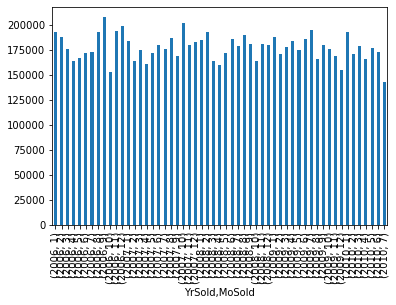

In [12]:
print(housing.groupby(['YrSold','MoSold'])['SalePrice'].aggregate(np.mean).plot(kind='bar'
                                                                              
                                                                             ))

In [13]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2568    121000
2569    139600
2570    145000
2571    217500
2572    215000
Name: SalePrice, Length: 2573, dtype: int64

In [14]:
#qual_related.GarageCond.value_counts()
#housing["exp_OverallQual"]= housing["OverallQual"].apply(lambda x: np.exp(x))
qual_related = housing.filter(regex='Qual$|Cond$|HeatingQC$|Qu$').fillna("TA")

qual_related

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,6,6,TA,TA,TA,TA,TA,TA,Gd,TA,TA
1,5,5,Gd,TA,Gd,TA,TA,Gd,TA,TA,TA
2,5,9,Gd,TA,TA,TA,Ex,Gd,TA,TA,Po
3,4,8,Gd,Gd,Fa,TA,Gd,TA,TA,TA,TA
4,8,6,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA
...,...,...,...,...,...,...,...,...,...,...,...
2568,6,6,TA,TA,TA,TA,Fa,Fa,Gd,Fa,Po
2569,3,5,TA,TA,TA,TA,Ex,TA,Gd,TA,TA
2570,5,6,TA,TA,TA,TA,TA,TA,TA,TA,TA
2571,7,5,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA


In [15]:
# Fill missing values vith TA
qual_related.fillna("TA", inplace=True)
def Rating(t):
    if t =="Ex": return  8
    elif t == "Gd": return 6
    elif t == "TA": return 4
    elif t == "Fa": return 3
    elif t == "Po": return 1
    else: return 0
for ele in qual_related.iloc[:,2:]:
    
    housing[ele]=qual_related[ele].map(Rating)
    qual_related[ele]=housing[ele]
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Year,lat,long,dist,income
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,0,3,2010,WD,Normal,2010,42.018564,-93.651619,0.998896,NaN
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,0,2,2009,WD,Normal,2009,42.024855,-93.663671,1.433537,21333.0
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,11,2007,WD,Normal,2007,NaN,NaN,NaN,NaN
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,0,5,2009,WD,Normal,2009,42.037391,-93.612207,3.072689,52375.0
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,0,11,2009,WD,Normal,2009,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,0,5,2009,WD,Normal,2009,42.032102,-93.626373,1.768156,37028.0
2569,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,0,6,2009,WD,Normal,2009,42.027669,-93.666138,1.626168,21333.0
2570,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,0,8,2007,WD,Normal,2007,42.020129,-93.643832,0.763415,20878.0
2571,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,0,7,2007,WD,Normal,2007,42.016802,-93.689748,3.739425,33311.0


In [16]:

ols = LinearRegression()
ols.fit(qual_related, housing["SalePrice"])

print(ols.score(qual_related, housing["SalePrice"]))

0.709539579360879


In [17]:
# Fill missing values vith TA

def yearidx(t):
    if t ==2006: return  1.186
    elif t == 2007: return 1.208
    elif t == 2008: return 1.198
    elif t == 2009: return 1.208
    elif t == 2010: return 1.19
    else: return 1.2

    
housing["GrLivArea_year"]=housing["YrSold"].map(yearidx)*housing["GrLivArea"]
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MoSold,YrSold,SaleType,SaleCondition,Year,lat,long,dist,income,GrLivArea_year
0,126000,909176150,856,30,RL,NaN,7890,Pave,NaN,Reg,...,3,2010,WD,Normal,2010,42.018564,-93.651619,0.998896,NaN,1018.640
1,139500,905476230,1049,120,RL,42.0,4235,Pave,NaN,Reg,...,2,2009,WD,Normal,2009,42.024855,-93.663671,1.433537,21333.0,1267.192
2,124900,911128020,1001,30,C (all),60.0,6060,Pave,NaN,Reg,...,11,2007,WD,Normal,2007,NaN,NaN,NaN,NaN,1209.208
3,114000,535377150,1039,70,RL,80.0,8146,Pave,NaN,Reg,...,5,2009,WD,Normal,2009,42.037391,-93.612207,3.072689,52375.0,1255.112
4,227000,534177230,1665,60,RL,70.0,8400,Pave,NaN,Reg,...,11,2009,WD,Normal,2009,42.044554,-93.631818,2.326978,61991.0,2011.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,121000,903205040,952,30,RL,NaN,8854,Pave,NaN,Reg,...,5,2009,WD,Normal,2009,42.032102,-93.626373,1.768156,37028.0,1150.016
2569,139600,905402060,1733,20,RL,NaN,13680,Pave,NaN,IR1,...,6,2009,WD,Normal,2009,42.027669,-93.666138,1.626168,21333.0,2093.464
2570,145000,909275030,2002,90,RH,82.0,6270,Pave,NaN,Reg,...,8,2007,WD,Normal,2007,42.020129,-93.643832,0.763415,20878.0,2418.416
2571,217500,907192040,1842,60,RL,NaN,8826,Pave,NaN,Reg,...,7,2007,WD,Normal,2007,42.016802,-93.689748,3.739425,33311.0,2225.136


In [18]:
housing.SaleType = housing.SaleType.apply(lambda x: 1 if x ==("New" or "Con") else 0)

In [19]:
grl = housing.groupby("Neighborhood").mean()[["GrLivArea"]]
#grl.rename({"GrLivArea":"GrLivArea_by_hood"}, inplace =True)
grl.columns=["GrLivArea_by_hood"]
housing = pd.merge(housing, grl, how='left', left_on='Neighborhood', right_on = 'Neighborhood')


In [20]:
housing.LotShape = np.where(housing.LotShape=="IR1", 1,0)

In [21]:

def bs2(t):
    if t =="ALD": return  1
    elif t == ("No Basement" or "Rec"): return -1
    else: return 0

housing['BsmtFinType2'] = housing['BsmtFinType2'].map(bs2)
    
    
       

In [22]:

def bs3(t):
    if t =="GLQ": return  1
    elif t == ("Unf"): return -1
    else: return 0

housing['BsmtFinType1'] = housing['BsmtFinType1'].map(bs3)
    
    
       

In [23]:
housing.BsmtFinType1

0       0
1       1
2       0
3      -1
4       1
       ..
2568   -1
2569    0
2570    0
2571    1
2572    1
Name: BsmtFinType1, Length: 2573, dtype: int64

In [24]:
housing.Heating =housing.Heating.apply(lambda x: -1 if x ==("GasW" or 'Grav') else 0)

In [25]:

housing.Functional = housing.Functional.apply(lambda x: 1 if x == ("Mod" or "Maj1" or "Maj2") else 0)


In [26]:
housing = housing.drop(['Utilities'], axis=1)

In [27]:

def bdt(t):
    if t ==("Duplex" or '2fmCon'): return  -1
    elif t == ("Twnhs"): return 1
    else: return 0

housing['BldgType'] = housing['BldgType'].map(bdt)
    
    
       

In [28]:
housing.groupby("Neighborhood").mean().sort_values(by="SalePrice") 

,SalePrice,PID,GrLivArea,MSSubClass,LotFrontage,LotArea,LotShape,BldgType,OverallQual,OverallCond,...,MoSold,YrSold,SaleType,Year,lat,long,dist,income,GrLivArea_year,GrLivArea_by_hood
Neighborhood,,,,,,,,,,,,,,,,,,,,,
MeadowV,96836.470588,9.232267e+08,1078.058824,161.176471,26.066667,2149.235294,0.000000,0.500000,4.382353,5.617647,...,5.676471,2007.911765,0.000000,2007.911765,41.991984,-93.603247,5.262644,59234.000000,1290.392353,1078.058824
BrDale,106094.827586,5.274509e+08,1111.689655,160.000000,21.517241,1846.172414,0.000000,0.793103,5.724138,5.448276,...,6.275862,2007.689655,0.000000,2007.689655,42.052062,-93.628320,3.196530,60500.000000,1331.847448,1111.689655
IDOTRR,108102.947368,9.088021e+08,1239.671053,61.513158,61.114286,8790.223684,0.039474,-0.013158,4.842105,5.750000,...,6.026316,2007.592105,0.000000,2007.592105,42.022936,-93.626766,1.691664,26009.000000,1487.954526,1239.671053
BrkSide,126029.854369,8.495431e+08,1237.932039,48.834951,55.945652,6988.669903,0.194175,0.000000,5.145631,6.213592,...,5.669903,2007.912621,0.000000,2007.912621,42.032386,-93.624982,1.905585,40663.388350,1485.563631,1237.932039
OldTown,126939.018779,8.438159e+08,1427.962441,63.779343,61.866995,8365.699531,0.051643,-0.023474,5.248826,6.469484,...,6.333333,2007.868545,0.000000,2007.868545,42.031249,-93.614391,2.726272,39544.152709,1711.606028,1427.962441
Edwards,131905.957055,9.070617e+08,1279.558282,54.539877,64.671141,9668.122699,0.153374,-0.049080,5.000000,5.588957,...,5.779141,2007.840491,0.006135,2007.840491,42.022004,-93.666790,1.783047,27723.014493,1533.327227,1279.558282
SWISU,133575.809524,9.084125e+08,1590.000000,69.404762,58.769231,7598.428571,0.095238,-0.047619,5.452381,5.714286,...,5.166667,2008.071429,0.000000,2008.071429,42.019896,-93.651088,0.976955,26032.384615,1901.881619,1590.000000
Landmrk,137000.000000,9.072302e+08,1320.000000,160.000000,NaN,3612.000000,1.000000,1.000000,6.000000,5.000000,...,6.000000,2006.000000,0.000000,2006.000000,NaN,NaN,NaN,NaN,1565.520000,1320.000000
Sawyer,137492.863309,7.790687e+08,1187.007194,44.460432,75.388889,10288.805755,0.402878,-0.079137,5.064748,5.769784,...,6.057554,2007.683453,0.000000,2007.683453,42.033258,-93.670655,2.146030,60833.000000,1421.114302,1187.007194


### UpSampling the Street labels

In [29]:
housing.Street.value_counts()
def Ratio(t):
    if t == 'Pave': return 1.0
   
    else: return 180.0
# the returned values must be integers   
ratios = housing['Street'].map(Ratio)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat')
index_repeat.shape

(4184,)

In [30]:
housing["Street"].value_counts()
housing["Street"] =housing["Street"].apply(lambda x: 1 if x=="Pave" else 0)
housing

,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,Year,lat,long,dist,income,GrLivArea_year,GrLivArea_by_hood
0,126000,909176150,856,30,RL,NaN,7890,1,NaN,0,...,2010,0,Normal,2010,42.018564,-93.651619,0.998896,NaN,1018.640,1590.000000
1,139500,905476230,1049,120,RL,42.0,4235,1,NaN,0,...,2009,0,Normal,2009,42.024855,-93.663671,1.433537,21333.0,1267.192,1279.558282
2,124900,911128020,1001,30,C (all),60.0,6060,1,NaN,0,...,2007,0,Normal,2007,NaN,NaN,NaN,NaN,1209.208,1239.671053
3,114000,535377150,1039,70,RL,80.0,8146,1,NaN,0,...,2009,0,Normal,2009,42.037391,-93.612207,3.072689,52375.0,1255.112,1427.962441
4,227000,534177230,1665,60,RL,70.0,8400,1,NaN,0,...,2009,0,Normal,2009,42.044554,-93.631818,2.326978,61991.0,2011.320,1699.138211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,121000,903205040,952,30,RL,NaN,8854,1,NaN,0,...,2009,0,Normal,2009,42.032102,-93.626373,1.768156,37028.0,1150.016,1237.932039
2569,139600,905402060,1733,20,RL,NaN,13680,1,NaN,1,...,2009,0,Normal,2009,42.027669,-93.666138,1.626168,21333.0,2093.464,1279.558282
2570,145000,909275030,2002,90,RH,82.0,6270,1,NaN,0,...,2007,0,Normal,2007,42.020129,-93.643832,0.763415,20878.0,2418.416,1705.032258
2571,217500,907192040,1842,60,RL,NaN,8826,1,NaN,0,...,2007,0,Normal,2007,42.016802,-93.689748,3.739425,33311.0,2225.136,1477.173729


housing = housing.loc[index_repeat].Street.value_counts()

In [31]:
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat", right_on=housing.index)

In [32]:
housing.SalePrice

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
4179    121000
4180    139600
4181    145000
4182    217500
4183    215000
Name: SalePrice, Length: 4184, dtype: int64

In [33]:
housing.isna().sum()

repeat                  0
SalePrice               0
PID                     0
GrLivArea               0
MSSubClass              0
                     ... 
long                  994
dist                  994
income               1258
GrLivArea_year          0
GrLivArea_by_hood       0
Length: 88, dtype: int64

In [34]:
housing.OverallQual

0       6
1       5
2       5
3       4
4       8
       ..
4179    6
4180    3
4181    5
4182    7
4183    8
Name: OverallQual, Length: 4184, dtype: int64

In [35]:
def Ratio2(t):
    if t =="Pave": return  20
    elif t == "Grvl": return 15
    else: return 1

ratios = housing['Alley'].map(Ratio2)
index_repeat = housing.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat1')
index_repeat
housing = pd.merge(index_repeat, housing, how='left', left_on = "repeat1", right_on=housing.index)
housing.shape


(6851, 89)

In [36]:
def fnd(t):
    if t =="PConc": return  1
    elif t == "CBlock": return 0
    else: return -0.5

housing['Foundation'] = housing['Foundation'].map(fnd)
    
    
       

In [37]:
housing.Alley.value_counts()

Grvl    1575
Pave    1260
Name: Alley, dtype: int64

In [38]:
def alley(t):
    if t =="Pave": return  1
    elif t == "Grvl": return 0
    else: return -0.1

housing['Alley'] = housing['Alley'].map(alley)
    
    
       

In [39]:
def style(t):
    if t =="1Story": return  1
    elif t == "2Story": return 2
    elif t == "1.5Fin": return 1.5
    else: return 0

housing['HouseStyle'] = housing['HouseStyle'].map(style)


In [40]:
def msz(t):
    if t ==("RM" or "C (all) "): return  -1
    elif t == "FV": return 1
  
    else: return 0

housing['MSZoning'] = housing['MSZoning'].map(msz)

In [41]:
housing.MSZoning.value_counts()

 0    3915
-1    2025
 1     911
Name: MSZoning, dtype: int64

In [42]:
housing["GarageType"].value_counts()

Detchd     3298
Attchd     2187
2Types      228
BuiltIn     190
CarPort     188
Basment      27
Name: GarageType, dtype: int64

In [43]:
def grg(t):
    if t ==("Attchd" or "Builtin") : return  1
    else: return 0
    -0.5

housing['GarageType'] = housing['GarageType'].map(grg)

In [44]:
def scond(t):
    if t ==("Partial") :
        return  1
    elif t == "Normal":
        return 0
    else: return -1

housing['SaleCondition'] = housing['SaleCondition'].map(scond)

In [45]:

def lnd(t):
    if t ==("HLS") :
        return  1
    elif t ==( "Bnk") :
        return  -1
   
    else: return 0

housing['LandContour'] = housing['LandContour'].map(lnd)

In [46]:

def bsmt(t):
    if t ==("Gd" or "Av") :
        return  2
    elif t ==( "Mn") :
        return  1
    elif t == "No Basement":
        return -1
   
    else: return 0

housing['BsmtExposure'] = housing['BsmtExposure'].map(bsmt)

In [47]:
def stype(t):
    if t ==("CWD") :
        return  2
    elif t ==("New") :
        return  1
    elif t == "Con":
        return 0.7
    if t ==("ConLD") :
        return  -1
    else: return 0

housing['SaleType'] = housing['SaleType'].map(stype)

In [48]:
housing["MasVnrType"] =np.where(housing["MasVnrType"]==("BrkCmn" or "Stone"),1,0)

In [49]:
housing["RoofStyle"] = np.where(housing["RoofStyle"] == "Hip",1,0)

In [50]:
# Checking unique PID #s
uni = housing.PID.unique()
uni.shape

(2572,)

In [51]:
housing.isna().sum()

repeat1                 0
repeat                  0
SalePrice               0
PID                     0
GrLivArea               0
                     ... 
long                 1130
dist                 1130
income               1492
GrLivArea_year          0
GrLivArea_by_hood       0
Length: 89, dtype: int64

In [52]:
np.exp(4.7)

109.94717245212352

<AxesSubplot:title={'center':'SalePrice'}, xlabel='Neighborhood'>

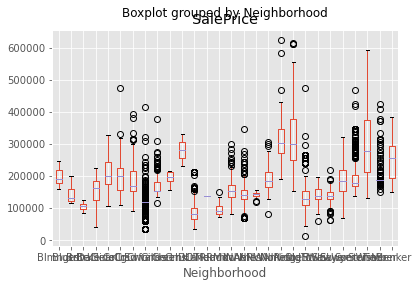

In [53]:
# How does the price vary by neighbourhood
plt.style.use('ggplot')



housing.boxplot(column ='SalePrice', by = 'Neighborhood')

In [54]:
# merging 2.5Unf values into 1Story
housing['HouseStyle'].replace('2.5Unf', '1Story', inplace=True)
# merging 2.5Fin to 2Story
housing['HouseStyle'].replace('2.5Fin', '2Story', inplace=True)
# merging 1.5Unf values into 1.5Fin
housing['HouseStyle'].replace('1.5Unf', '1.5Fin', inplace=True)

In [55]:
housing.HouseStyle.value_counts()

1.0    3066
2.0    2104
1.5    1145
0.0     536
Name: HouseStyle, dtype: int64

### Encoding and Dummyfication

In [56]:
# get the averge price by neighborhood
dummy2 = housing.groupby(["YrSold"])[["SalePrice"]].mean()
dummy2.rename(columns = {"SalePrice":"Price_by_yr"}, inplace =True)
dummy2

,Price_by_yr
YrSold,
2006,145412.995050
2007,164411.563473
2008,139083.737406
2009,150699.883234
2010,148515.221643


In [57]:

housing = pd.merge(housing, dummy2, how='left', on=['YrSold', 'YrSold'])
housing

,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,SaleType,SaleCondition,Year,lat,long,dist,income,GrLivArea_year,GrLivArea_by_hood,Price_by_yr
0,0,0,126000,909176150,856,30,0,NaN,7890,1,...,0,0,2010,42.018564,-93.651619,0.998896,NaN,1018.640,1590.000000,148515.221643
1,1,1,139500,905476230,1049,120,0,42.0,4235,1,...,0,0,2009,42.024855,-93.663671,1.433537,21333.0,1267.192,1279.558282,150699.883234
2,2,2,124900,911128020,1001,30,0,60.0,6060,1,...,0,0,2007,NaN,NaN,NaN,NaN,1209.208,1239.671053,164411.563473
3,3,3,114000,535377150,1039,70,0,80.0,8146,1,...,0,0,2009,42.037391,-93.612207,3.072689,52375.0,1255.112,1427.962441,150699.883234
4,4,4,227000,534177230,1665,60,0,70.0,8400,1,...,0,0,2009,42.044554,-93.631818,2.326978,61991.0,2011.320,1699.138211,150699.883234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,4179,2568,121000,903205040,952,30,0,NaN,8854,1,...,0,0,2009,42.032102,-93.626373,1.768156,37028.0,1150.016,1237.932039,150699.883234
6847,4180,2569,139600,905402060,1733,20,0,NaN,13680,1,...,0,0,2009,42.027669,-93.666138,1.626168,21333.0,2093.464,1279.558282,150699.883234
6848,4181,2570,145000,909275030,2002,90,0,82.0,6270,1,...,0,0,2007,42.020129,-93.643832,0.763415,20878.0,2418.416,1705.032258,164411.563473
6849,4182,2571,217500,907192040,1842,60,0,NaN,8826,1,...,0,0,2007,42.016802,-93.689748,3.739425,33311.0,2225.136,1477.173729,164411.563473


In [58]:
# get the averge price by neighborhood
dummy2 = housing.groupby(["MoSold"])[["SalePrice"]].mean()
dummy2.rename(columns = {"SalePrice":"Price_by_month"}, inplace =True)

housing = pd.merge(housing, dummy2, how='left', on=['MoSold','MoSold'])
housing


,repeat1,repeat,SalePrice,PID,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,SaleCondition,Year,lat,long,dist,income,GrLivArea_year,GrLivArea_by_hood,Price_by_yr,Price_by_month
0,0,0,126000,909176150,856,30,0,NaN,7890,1,...,0,2010,42.018564,-93.651619,0.998896,NaN,1018.640,1590.000000,148515.221643,133047.651475
1,1,1,139500,905476230,1049,120,0,42.0,4235,1,...,0,2009,42.024855,-93.663671,1.433537,21333.0,1267.192,1279.558282,150699.883234,163437.446746
2,2,2,124900,911128020,1001,30,0,60.0,6060,1,...,0,2007,NaN,NaN,NaN,NaN,1209.208,1239.671053,164411.563473,170739.569565
3,3,3,114000,535377150,1039,70,0,80.0,8146,1,...,0,2009,42.037391,-93.612207,3.072689,52375.0,1255.112,1427.962441,150699.883234,150102.980769
4,4,4,227000,534177230,1665,60,0,70.0,8400,1,...,0,2009,42.044554,-93.631818,2.326978,61991.0,2011.320,1699.138211,150699.883234,170739.569565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,4179,2568,121000,903205040,952,30,0,NaN,8854,1,...,0,2009,42.032102,-93.626373,1.768156,37028.0,1150.016,1237.932039,150699.883234,150102.980769
6847,4180,2569,139600,905402060,1733,20,0,NaN,13680,1,...,0,2009,42.027669,-93.666138,1.626168,21333.0,2093.464,1279.558282,150699.883234,149018.994113
6848,4181,2570,145000,909275030,2002,90,0,82.0,6270,1,...,0,2007,42.020129,-93.643832,0.763415,20878.0,2418.416,1705.032258,164411.563473,141536.996622
6849,4182,2571,217500,907192040,1842,60,0,NaN,8826,1,...,0,2007,42.016802,-93.689748,3.739425,33311.0,2225.136,1477.173729,164411.563473,149674.039216


In [59]:
housing.isna().sum()

repeat1                 0
repeat                  0
SalePrice               0
PID                     0
GrLivArea               0
                     ... 
income               1492
GrLivArea_year          0
GrLivArea_by_hood       0
Price_by_yr             0
Price_by_month          0
Length: 91, dtype: int64

In [60]:
housing.SaleType.value_counts()

0    6851
Name: SaleType, dtype: int64

In [61]:
housing.columns

Index(['repeat1', 'repeat', 'SalePrice', 'PID', 'GrLivArea', 'MSSubClass',
       'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

In [62]:

# We trim the outliers from the list
#housing = housing
#leng = len(housing)
#print(leng)
#housing["Gradient"] = (housing.SalePrice-15000)/(housing.GrLivArea)

#housing=housing.sort_values(by="Gradient")[(housing.sort_values(by="Gradient")["Gradient"]>30) & (housing.sort_values(by="Gradient")["Gradient"]<220)]
#housing["Gradient2"] = (housing.SalePrice)/(housing.GrLivArea-1600.01) 
#housing=housing.sort_values(by="Gradient2")[ (housing.sort_values(by="Gradient2")["Gradient2"]>250)|(housing.sort_values(by="Gradient2")["Gradient2"]<0)]
#housing["Gradient3"] = (housing.SalePrice -100000)/(housing.TotalBsmtSF +1) 
#housing=housing.sort_values(by="Gradient3")[ (housing.sort_values(by="Gradient3")["Gradient3"]<200)]
#housing["Gradient4"] = (housing.SalePrice)/(housing.TotalBsmtSF-1200.01) 
#housing=housing.sort_values(by="Gradient4")[ (housing.sort_values(by="Gradient4")["Gradient4"]>300000/1300)|(housing.sort_values(by="Gradient4")["Gradient4"]<0)]

#housing
#leng2 = len(housing)
#outlier_pct = 100*(leng-leng2)/leng
#outlier_pct


In [63]:
housing.PavedDrive = np.where(housing.PavedDrive=="N", 0,1)
housing.CentralAir = np.where(housing.CentralAir=="N", 0,1)

### Fixing Missing Values

In [64]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_pct = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_pct], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10] 
    

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_7041/2694707503.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return mis_val_table_ren_columns.sort_values(by= "Missing Values")[mis_val_table_ren_columns["Missing Values"]>10]


<AxesSubplot:>

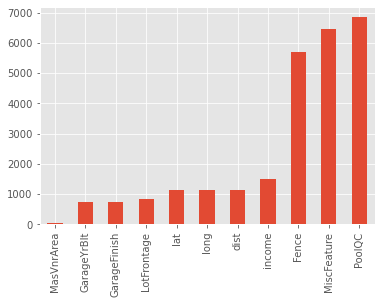

In [65]:
missing_values_table(housing)["Missing Values"].plot.bar()

In [66]:
housing=housing.drop(["MiscFeature"], axis=1)

In [67]:
housing[housing.columns[housing.isnull().any()]]

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PoolQC,Fence,lat,long,dist,income
0,NaN,0.0,238.0,0.0,618.0,856.0,SBrkr,1.0,0.0,1939.0,Unf,2.0,399.0,NaN,NaN,42.018564,-93.651619,0.998896,NaN
1,42.0,149.0,552.0,393.0,104.0,1049.0,SBrkr,1.0,0.0,1984.0,Fin,1.0,266.0,NaN,NaN,42.024855,-93.663671,1.433537,21333.0
2,60.0,0.0,737.0,0.0,100.0,837.0,SBrkr,0.0,0.0,1930.0,Unf,1.0,216.0,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,0.0,0.0,0.0,405.0,405.0,SBrkr,0.0,0.0,1940.0,Unf,1.0,281.0,NaN,NaN,42.037391,-93.612207,3.072689,52375.0
4,70.0,0.0,643.0,0.0,167.0,810.0,SBrkr,1.0,0.0,2001.0,Fin,2.0,528.0,NaN,NaN,42.044554,-93.631818,2.326978,61991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,NaN,0.0,0.0,0.0,952.0,952.0,FuseF,0.0,0.0,1916.0,Unf,1.0,192.0,NaN,NaN,42.032102,-93.626373,1.768156,37028.0
6847,NaN,0.0,0.0,0.0,0.0,0.0,FuseA,0.0,0.0,1955.0,Unf,2.0,452.0,NaN,NaN,42.027669,-93.666138,1.626168,21333.0
6848,82.0,0.0,284.0,0.0,717.0,1001.0,FuseA,0.0,0.0,1949.0,Unf,3.0,871.0,NaN,NaN,42.020129,-93.643832,0.763415,20878.0
6849,NaN,144.0,841.0,0.0,144.0,985.0,SBrkr,1.0,0.0,2000.0,Fin,2.0,486.0,NaN,NaN,42.016802,-93.689748,3.739425,33311.0


### "Proximity to various Conditions"

The columns *Condition 1* and *Condition 2* have the same realizations and can be regarded as "tags" given to a house indicating the nearby presence of a) a major street, b) a railroad, or c) a park.

The default tag "Norm" (implying no "condition") is given to 86% of the houses 

In [68]:
housing["Condition1"] = housing["Condition1"].apply(lambda x: 0 if x =="Norm" else 1)
housing["Condition2"] = housing["Condition2"].apply(lambda x: 0 if x =="Norm" else 1)


In [69]:
#changing the NA values which aren't NAs to different values to work better with the data set
medl = housing.LotFrontage.median()
medm = housing.MasVnrArea.median()
housing.Alley = housing.Alley.fillna("No Alley Access")
housing.LotFrontage = housing.LotFrontage.fillna(medl)
housing.MasVnrArea = housing.MasVnrArea.fillna(medm)
housing.MasVnrType = housing.MasVnrType.fillna('None')
housing.BsmtQual = housing.BsmtQual.fillna("No Basement")


In [70]:

housing.PoolQC = housing.PoolQC.fillna(0)
housing.PoolQC=np.where(housing.PoolQC==0, 0,1)

In [71]:
# Fill the NA with the right values
housing.BsmtCond = housing.BsmtCond.fillna("No Basement")
housing.BsmtExposure = housing.BsmtExposure.fillna("No Basement")
housing.BsmtFinType1 = housing.BsmtFinType1.fillna("No Basement")
housing.BsmtFinType2 = housing.BsmtFinType2.fillna("No Basement")
housing.FireplaceQu = housing.FireplaceQu.fillna("No Fireplace")
housing.GarageType = housing.GarageType.fillna("No Garage")
housing.GarageFinish = housing.GarageFinish.fillna("No Garage")
housing.GarageQual = housing.GarageQual.fillna("No Garage")
housing.GarageCond = housing.GarageCond.fillna("No Garage")
housing.Fence = housing.Fence.fillna("No Fence")
housing.Electrical = housing.Electrical.fillna("None")
housing['TotalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
tfmed=housing.TotalSF.mean()
housing.TotalSF.fillna(tfmed, inplace=True)
#housing['PricePerSF'] = housing['SalePrice']/(housing['TotalSF']+0.1)

In [72]:
def ext(t):
    if t in  ['PreCast',  'ImStucc', 'CemntBd']:
        return 1
    elif t in ['AsphShn', 'AsbShng', 'CBlock']:
        return -1
    else: 
        return 0
housing['Exterior1st'] = housing['Exterior1st'].map(ext)
housing['Exterior2nd'] = housing['Exterior2nd'].map(ext)

for i in range(len(housing["Exterior1st"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0
for i in range(len(housing["Exterior2nd"])):
    if housing["Exterior1st"][i] in  ['PreCast',  'ImStucc', 'CemntBd']:
        housing["Exterior1st"][i] =1
    elif housing["Exterior1st"][i] in ['AsphShn', 'AsbShng', 'CBlock']:
        housing["Exterior1st"][i] =-1
    else: 
        housing["Exterior1st"][i] =0    


In [73]:
# Unify the two townhouse types into one.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "Twnhs" if x in ("TwnhsE", "TwnhsI") else x
)
# Unify the two kinds of 2-family homes.
housing["BldgType"] = housing["BldgType"].apply(
    lambda x: "2Fam" if x in ("2FmCon", "Duplx") else x
)

In [74]:

med1 = housing.BsmtFinSF1.median()
med2 = housing.BsmtFinSF2.median()
medf = housing.BsmtUnfSF.median()
medt = housing.TotalBsmtSF.median()
meda = housing.GarageArea.median()
medlon =housing.long.median()
medlat = housing.lat.median()
medist = housing.dist.median()
medinc = housing.income.median()

housing.BsmtFinSF1 = housing.BsmtFinSF1.fillna(med1)
housing.BsmtFinSF2 = housing.BsmtFinSF2.fillna(med2)
housing.BsmtUnfSF = housing.BsmtUnfSF.fillna(medf)
housing.TotalBsmtSF = housing.TotalBsmtSF.fillna(medt)
housing.GarageArea = housing.GarageArea.fillna(meda)
housing.long = housing.long.fillna(medlon)
housing.lat = housing.lat.fillna(medlat)
housing.dist = housing.dist.fillna(medist)
housing.income = housing.income.fillna(medinc)

housing.BsmtFullBath = housing.BsmtFullBath.fillna(0.0)
housing.BsmtHalfBath = housing.BsmtHalfBath.fillna(0.0)
housing.GarageCars = housing.GarageCars.fillna(0.0)

housing.GarageYrBlt = np.where(housing.GarageYrBlt.notnull(),housing.GarageYrBlt, housing.YearBuilt)

housing.TotalBsmtSF = np.where(housing.TotalBsmtSF<20,800, housing.TotalBsmtSF)
housing.BsmtFinSF1 = np.where(housing.BsmtFinSF1<20,800, housing.BsmtFinSF1)


In [75]:
# We covert the year to age and take the squareroot to normalise the values
housing.YearBuilt = np.sqrt(2010 - housing.YearBuilt)
housing.GarageYrBlt = np.sqrt(2010 - housing.GarageYrBlt)
housing.YrSold = np.sqrt(2010 -housing.YrSold)
housing.YearRemodAdd = np.sqrt(2010 -housing.YearRemodAdd)

In [76]:
housing.YearBuilt

0        8.426150
1        5.099020
2        8.944272
3       10.488088
4        3.000000
          ...    
6846     9.695360
6847     7.416198
6848     7.810250
6849     3.162278
6850     4.123106
Name: YearBuilt, Length: 6851, dtype: float64

In [77]:
# Creation of new column combining full and half bathrooms into one
bathrm = (housing['FullBath'] + housing['BsmtFullBath'] +
(housing['HalfBath']*0.5) + (housing['BsmtHalfBath']*0.5))
housing['bathrm_cnt'] = bathrm

# Creation of new column combining deck/porch-related sq footage into one
patioSF = (housing['WoodDeckSF'] + housing['OpenPorchSF']+ housing['EnclosedPorch'] + 
           housing['3SsnPorch'] + housing['ScreenPorch'])
housing['patioSF'] = patioSF

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


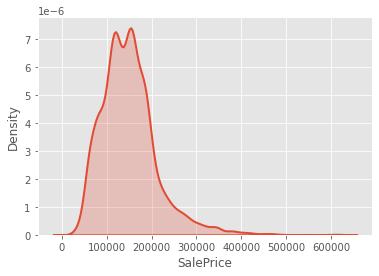

In [78]:
sns.distplot(housing.SalePrice, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [79]:
housing["SalePrice"].mean()

149698.48693621368

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  16.,   1.,  21.,   0.,   2.,  15.,  19., 199., 206.,  34.,
         42., 420.,  52., 295., 170., 474., 553., 422., 409., 536., 747.,
        533., 536., 304., 213., 166., 107., 119.,  65.,  52.,  48.,  25.,
         21.,   9.,   8.,   2.,   3.,   6.]),
 array([ 9.45641889,  9.53420069,  9.61198248,  9.68976427,  9.76754607,
         9.84532786,  9.92310965, 10.00089144, 10.07867324, 10.15645503,
        10.23423682, 10.31201861, 10.38980041, 10.4675822 , 10.54536399,
        10.62314578, 10.70092758, 10.77870937, 10.85649116, 10.93427296,
        11.01205475, 11.08983654, 11.16761833, 11.24540013, 11.32318192,
        11.40096371, 11.4787455 , 11.5565273 , 11.63430909, 11.71209088,
        11.78987268, 11.86765447, 11.94543626, 12.02321805, 12.10099985,
        12.17878164, 12.25656343, 12.33434522, 12.41212702, 12.48990881,
        12.5676906 , 12.64547239, 12.72325419, 12.80103598, 12.87881777,
 

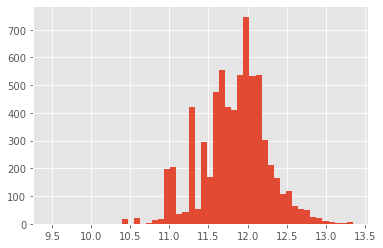

In [80]:
#use the log function to make the data normal
plt.hist(np.log(housing.SalePrice+1), bins = 50)

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


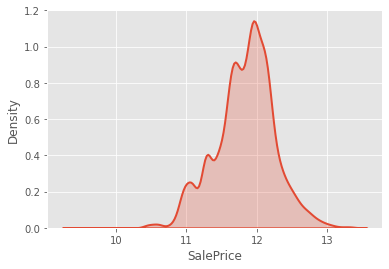

In [81]:
sns.distplot(np.log(housing.SalePrice+1), hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2})
plt.show()

In [82]:
np.log(housing["SalePrice"]).mean()

11.831230089521824

## Check Extreme outliers

6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


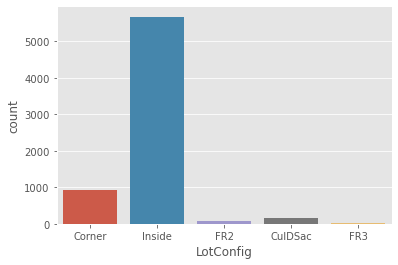

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


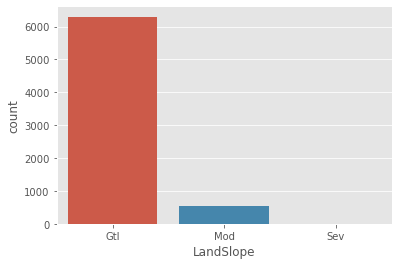

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


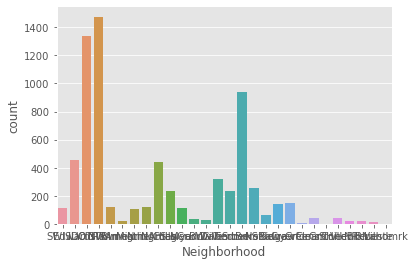

6851
6851
6851
6851
6851
6851
6851
6851
6851


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


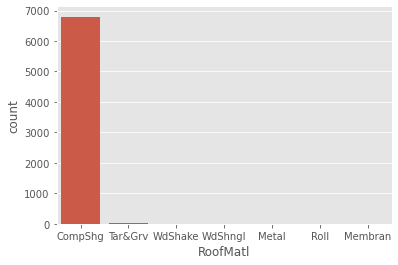

6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


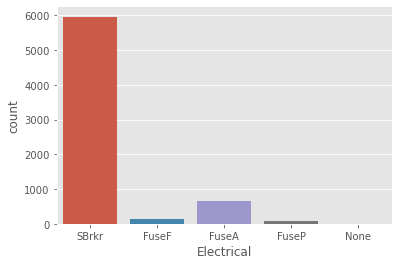

6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


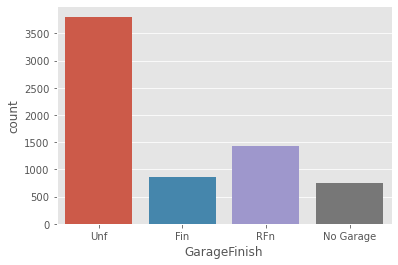

6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851


/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


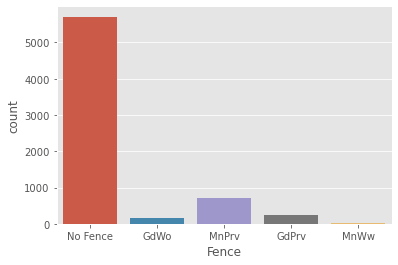

6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851
6851


In [83]:
# Keep the numerical data to the left and categorical data to the right.
# Visualise the proportion of each categorical labels
categorical_data=[]
housing_new =pd.DataFrame()
#print(len(housing_new))
housing_new["SalePrice"]=housing["SalePrice"]
for ele in housing.columns:
    if np.dtype(housing[ele])== "int64" or np.dtype(housing[ele])=="float64":
        housing_new[ele] = housing[ele]
        print(len(housing_new))
    else:
        categorical_data.append(ele)
        sns.countplot(housing[ele])
    plt.show()

In [84]:

#houisng = housing.drop(["YrMoSold"], axis=1)
#houisng = housing.drop(["YrMoSold"], axis=1)
#housing.to_csv("clean_housing.csv")

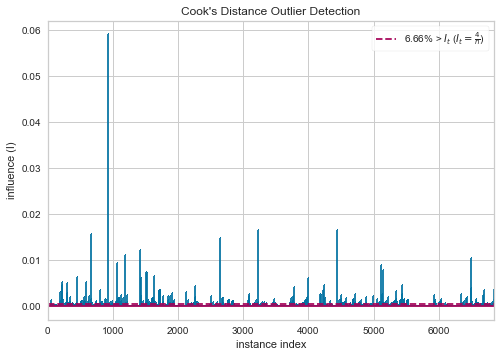

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [85]:
from yellowbrick.regressor import CooksDistance

X= housing_new.iloc[:,1:]
y=np.log(housing_new["SalePrice"])

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()



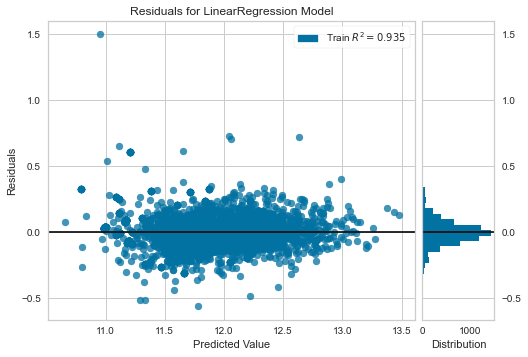

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [86]:

from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

/Users/maejok/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


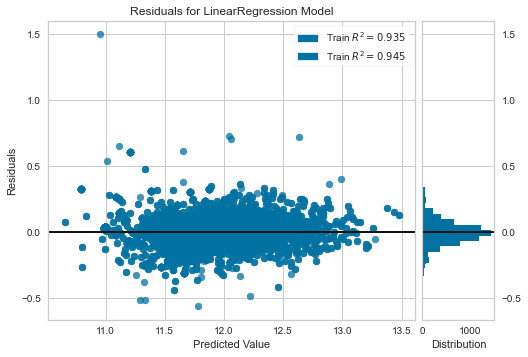

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [87]:
# We use the cooks distance to filter outlirs that are more than 5 time the influence threshold. !6 rows were removed
i_less_influential = (visualizer.distance_ <= 5*visualizer.influence_threshold_)
housing_new = housing_new[i_less_influential]
housing = housing[i_less_influential]
X= housing_new.iloc[:,1:]
y=np.log(housing_new["SalePrice"])
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

In [88]:
from scipy.stats import skew
# Check the skew of all numerical features
col_skewed= housing_new.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :col_skewed})
skewness.head(20)


Skew in numerical features: 



,Skew
PoolArea,82.425725
PoolQC,82.425725
MiscVal,21.175565
3SsnPorch,20.130459
Condition2,17.103366
LowQualFinSF,14.366534
Functional,10.241984
MasVnrType,5.615371
BsmtHalfBath,4.975886
KitchenAbvGr,4.464581


### Log tranform to avoid skewness

In [89]:
housing_new["PoolArea"]  = housing_new["PoolArea"].apply(lambda x: np.log(x+1))
housing_new["PoolQC"]  = housing_new["PoolQC"].apply(lambda x: np.log(x+1))
housing_new["MiscVal"]  = housing_new["MiscVal"].apply(lambda x: np.log(x+1))
housing_new["3SsnPorch"]  = housing_new["3SsnPorch"].apply(lambda x: np.log(x+1))
housing_new["Condition2"]  = housing_new["Condition2"].apply(lambda x: np.log(x+1))
housing_new["LowQualFinSF"]  = housing_new["LowQualFinSF"].apply(lambda x: np.log(x+1))
housing_new["Functional"]  = housing_new["Functional"].apply(lambda x: np.log(x+1))
housing_new["MasVnrArea"]  = housing_new["MasVnrArea"].apply(lambda x: np.log(x+1))
housing_new["KitchenAbvGr"]  = housing_new["KitchenAbvGr"].apply(lambda x: np.log(x+1))
housing_new["BsmtHalfBath"]  = housing_new["BsmtHalfBath"].apply(lambda x: np.log(x+1))
housing_new["MasVnrType"]  = housing_new["MasVnrType"].apply(lambda x: np.log(x+1))

In [90]:
for name in categorical_data:
    print(name, ': number of values', len(housing[name].value_counts()))

LotConfig : number of values 5
LandSlope : number of values 3
Neighborhood : number of values 27
RoofMatl : number of values 7
Electrical : number of values 5
GarageFinish : number of values 4
Fence : number of values 5


In [91]:
for ele in categorical_data:
    housing_new[ele] = housing[ele]

In [92]:
# Get the dummies of each categorical Data.
for ele in categorical_data:
    # Converting type of columns to category
    housing_new=pd.get_dummies(housing_new, prefix="{}_".format(ele), 
                            columns=[ele], 
                            drop_first=True)
    

housing_new=housing_new.drop(["repeat","repeat1"], axis=1)

In [93]:
housing.to_csv("clean_housing.csv")

In [94]:
#qual_related.GarageCond.value_counts()
#housing["exp_OverallQual"]= housing["OverallQual"].apply(lambda x: np.exp(x))
qual_related = housing.filter(regex='Qual$|Cond$|HeatingQC$|Qu$').fillna("TA")


In [95]:

size_related = housing.filter(regex='SF$|Area$')
ols.fit(size_related, housing["SalePrice"])

print(ols.score(size_related, housing["SalePrice"]))

0.7681600173328563


In [96]:
#housing["exp_OverallQual"]= housing["OverallQual"].apply(lambda x: np.exp(x))
nbh = housing_new.filter(regex='^Neighborhood').fillna("TA")

ols.fit(nbh, housing["SalePrice"])

print(ols.score(nbh, housing["SalePrice"]))

0.6070357806440324


In [97]:
#s=list(qual_related.columns) 
q =list(size_related.columns)
n =list(nbh.columns)
qn = housing_new[q+n]
ols.fit(qn, housing_new["SalePrice"])

print(ols.score(qn, housing["SalePrice"]))

0.8511396556333668


In [98]:
s=list(qual_related.columns) 
d = list(housing[['dist']].columns)
sd = housing_new[s+d]
ols.fit(sd, housing_new["SalePrice"])

print(ols.score(sd, housing["SalePrice"]))

0.6996227004422583


In [99]:
s=list(qual_related.columns) 
q =list(size_related.columns)
n =list(nbh.columns)
d = housing[['dist']].columns
sqn = housing_new[s+q+n]
ols.fit(sqn, housing_new["SalePrice"])

print(ols.score(sqn, housing["SalePrice"]))

0.9139031758159263


In [100]:
from sklearn.decomposition import PCA
pca=PCA(n_components=4)
exp_ratio = []
pca.set_params(n_components=4)


principal_components_ = pca.fit_transform(size_related)



total_var = sum(pca.explained_variance_ratio_)*100
housing["PCA_1"] =   list(principal_components_[:,0]) # Add the first pricipal component to the data1
#housing["PCA_2"] =   list(principal_components_[:,1]) # Add the first pricipal component to the data1


exp_ratio.append(pca.explained_variance_ratio_[0]) 
#exp_ratio.append(pca.explained_variance_ratio_[1]) 


In [101]:
exp_ratio

[0.967692906964817]

In [102]:
pca=PCA(n_components=3)
exp_ratio = []
pca.set_params(n_components=3)


principal_components_ = pca.fit_transform(housing[s+q])



total_var = sum(pca.explained_variance_ratio_)*100
housing["PCA_2"] =   list(principal_components_[:,0]) # Add the first pricipal component to the data1


exp_ratio.append(pca.explained_variance_ratio_[0]) 

exp_ratio.append(pca.explained_variance_ratio_[2]) 

In [103]:
exp_ratio

[0.9676926121144835, 0.00552676916752433]

In [104]:
pca=PCA(n_components=3)
exp_ratio = []
pca.set_params(n_components=3)


principal_components_ = pca.fit_transform(nbh)



total_var = sum(pca.explained_variance_ratio_)*100
housing["PCA_3"] =   list(principal_components_[:,0]) # Add the first pricipal component to the data1


exp_ratio.append(pca.explained_variance_ratio_[0]) 

exp_ratio.append(pca.explained_variance_ratio_[2]) 

In [105]:
housing_new.to_csv("housing_new.csv")

/var/folders/04/cszrdrg50q9gqrdnh622flsh0000gn/T/ipykernel_7041/3332410538.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


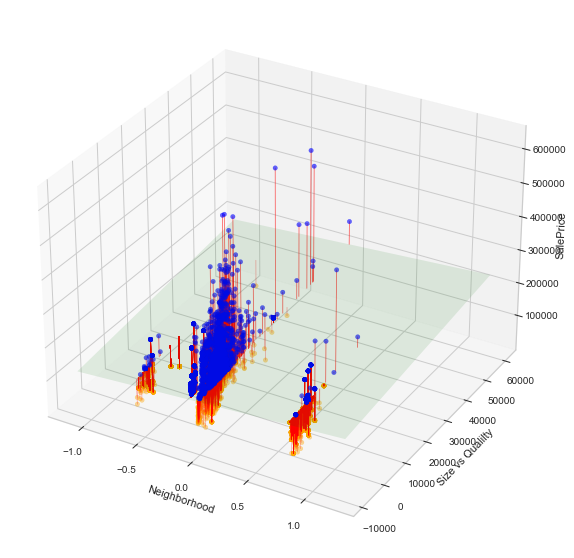

In [106]:
## 3D scatter plot
housing_plot3 = housing[['PCA_3', "PCA_2"]]
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(housing_plot3, housing["SalePrice"])

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
price= housing["SalePrice"]
N = len(price)
beta = np.array([np.round(ols.intercept_, 1), np.round(ols.coef_, 1)[0], np.round(ols.coef_, 1)[1]])
x_m = np.array(housing_plot3.head(N)) #np.random.randn(N, 2)
y_m = np.array(price.head(N))#np.dot(np.append(np.ones((N,1)), x_m, axis=1), beta) + np.random.randn(N)*4
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection='3d')
# plot the data points
X = np.array(list(map(lambda x: [1]+ list(x), x_m)))  # Idiomatic Py3, but inefficient on Py2
up = np.where(y_m >= np.sum(X*beta, axis=1))[0]
down = np.where(y_m < np.sum(X*beta, axis=1))[0]
ax.scatter(x_m[up, 0], x_m[up, 1], y_m[up], c='blue', alpha=.6)
ax.scatter(x_m[down, 0], x_m[down, 1], y_m[down], c='orange', alpha=.4)

# plot the error bars
ax = fig.gca(projection='3d')
x_up = x_m[up,:]; y_up = y_m[up]
up_kwargs = dict(color='red', alpha=.6, lw=0.8)
for i, j, k in zip(x_up[:, 0], x_up[:, 1], y_up):
    ax.plot([i, i], [j, j], [k, np.dot(beta, [1, i, j])], **up_kwargs)
    
x_down = x_m[down,:]; y_down = y_m[down]
down_kwargs = dict(color='red', alpha=.3, lw=0.8)
for i, j, k in zip(x_down[:,0], x_down[:,1], y_down):
    ax.plot([i, i], [j, j], [k, np.dot(beta, [1, i, j])], **down_kwargs)
    
    
# plot the plane which represents the true model
x_1 = np.linspace(min(x_m[:, 0])-.5, max(x_m[:, 0])+.5, 25)
x_2 = np.linspace(min(x_m[:, 1])-.5, max(x_m[:, 1])+.5, 25)
x_1, x_2 = np.meshgrid(x_1, x_2)
x_3 = beta[1]*x_1 + beta[2]*x_2 + beta[0]
surface_kwargs = dict(rstride=100, cstride=100, color='green', alpha=0.1)
ax.plot_surface(x_1, x_2, x_3, **surface_kwargs)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Size vs Qualilty')
ax.set_zlabel('SalePrice')
plt.show()

# Fit the data 

In [107]:
from scipy import stats
fitted_price, fitted_lambda = stats.boxcox(housing_new["SalePrice"])
fitted_lambda

0.10681428816486145

In [108]:
from sklearn.model_selection import train_test_split
from itertools import combinations
 
# Get all combinations of according to the best contributions in increasing the R^2
# The process creates a partail ording among the predictors where A rel B if A is Subset of B and R2A <=R2B
# The time complexity of this process is n* nC1=n**2 where n is the number of columns
fnlst =[]
cscores =[]
labels=[]
for ele in range(1,len(housing_new.columns),1):
    
    comb = combinations(housing_new.iloc[:,1:].columns.difference(fnlst), 1)

    lst=[]
    scores=[]
   
    # Print the obtained combinations
    for i in list(comb):
        ols = LinearRegression()
        
        X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst+list(i)], np.log(fitted_price + 1), test_size=0.5, random_state=0)
        #lst.append(list(i))
        ols.fit(X_train, y_train)
        lst.append(list(i))
        scores.append(ols.score(X_train, y_train))
    if len(cscores)<30:
        
        cscores.append(pd.Series(scores).max())
        fnlst =fnlst+lst[pd.Series(scores)[pd.Series(scores)==pd.Series(scores).max()].index[0]]
    if fnlst[-1:][0]!=[] and len(labels)<30:
        labels.append(fnlst[-1:][0])





ols = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(housing_new[fnlst], fitted_price, test_size=0.5, random_state=32)

ols.fit(X_train, y_train)
print('-'*50)

print("R^2 for train set: %f" %ols.score(X_train, y_train))
print("R^2 for test set: %f" %ols.score(X_test, y_test))

print('-'*50)
print(labels)



--------------------------------------------------
R^2 for train set: 0.947701
R^2 for test set: 0.947657
--------------------------------------------------
['TotalSF', 'OverallQual', 'YearBuilt', 'OverallCond', 'BsmtUnfSF', 'GarageCond', 'Neighborhood__BrkSide', 'GrLivArea_by_hood', 'GarageArea', 'Fireplaces', 'YearRemodAdd', 'Neighborhood__Crawfor', 'Foundation', 'MSSubClass', 'GrLivArea', 'Neighborhood__IDOTRR', 'patioSF', 'HouseStyle', 'Neighborhood__Edwards', 'Neighborhood__SWISU', 'GarageQual', 'BldgType', 'KitchenAbvGr', 'income', 'Condition1', 'GrLivArea_year', 'OpenPorchSF', 'Neighborhood__MeadowV', 'ScreenPorch', 'GarageYrBlt']


Text(0, 0.5, 'R-Squared')

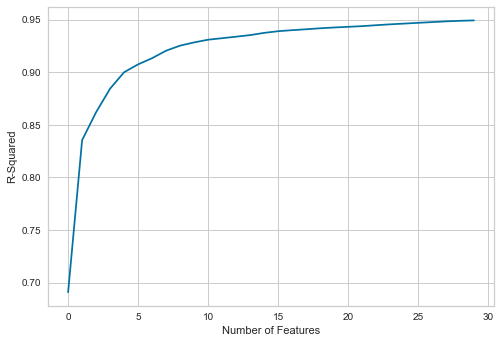

In [109]:

plt.plot(range(len(cscores)), cscores)
plt.xlabel("Number of Features")
plt.ylabel("R-Squared")

In [110]:

lr = linear_model.LinearRegression()
model_lr = lr.fit(X_train, y_train)

In [111]:
from sklearn.metrics import mean_squared_error
predictions = model_lr.predict(X_test)
print ('RMSE is: \n', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE is: 
 0.332777231570324
